# PCA + Local Moran's I

We start with our PCA:

In [1]:
import pandas as pd
import geopandas as gpd
import helpers
import pygris 
import matplotlib.pyplot as plt
import contextily as ctxly
from esda.moran import Moran_Local_BV, Moran_BV
from libpysal.weights.distance import Kernel
from splot.esda import lisa_cluster, moran_scatterplot
from sklearn.preprocessing import PowerTransformer

In [2]:
pd.read_csv('../data/finance_pca_loadings.csv')

,Unnamed: 0,component,explained_var,medHouseIncome,unemplRate,perOwnerOcc,percentPov,percentCarCom,percentRentBurd
0,0,0,0.463656,-0.460696,0.350685,-0.466367,-0.533795,-0.314714,0.251593
1,1,1,0.224048,-0.335897,0.133956,0.420911,-0.124647,0.640843,0.515604
2,2,2,0.133474,0.001839,0.779370,0.139406,-0.004596,0.207759,-0.574422


Our first component captures 46.36% of the variance between our variables, which is not perfect but is certainly strong performance (and stronger than in our exploration lab)!. Notably, higher values in this variable indicate lower income, higher rent burden, and higher unemployment, making it a good **Financial Precarity Index**.

In [3]:
finance = helpers.cleanly_read_parquet('../data/finance_pca_results.parquet', names=['FinPredInc', 'Meh', 'Meh2'])

nyc = gpd.read_file('../data/shapes/nyc_census_imputed.gpkg')
orig = nyc[['GEOID', 'geometry']].copy()
nyc['FinPrec'] = finance.FinPredInc

Using the default year of 2021
Using FIPS code '36' for input 'NY'
EPSG:4269


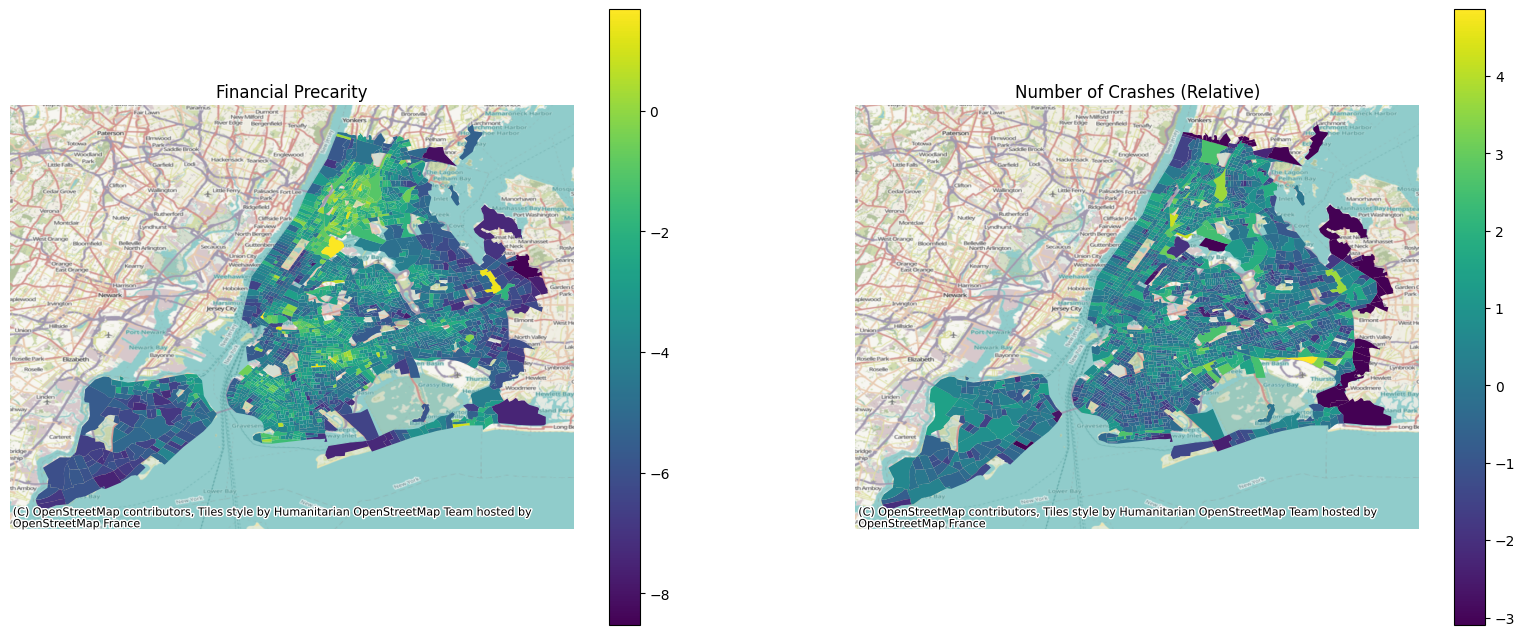

In [4]:
pt = PowerTransformer()

nyc = nyc[nyc.totalPop != 0]
nyc['numCrashesRel'] = pt.fit_transform(nyc[['numCrashes']])

fig, axes = plt.subplots(1, 2)

fig.set_figwidth(20)
fig.set_figheight(8)

# Retrieve cartographic boundaries
pretty_tracts = pygris.tracts(state='NY', cb=True, cache=True)[['GEOID', 'geometry']]

print(pretty_tracts.crs)

nyc_mapping = nyc.drop('geometry', axis=1).merge(pretty_tracts, on='GEOID')
nyc_mapping = gpd.GeoDataFrame(nyc_mapping, geometry=nyc_mapping.geometry)

nyc_mapping.plot(nyc_mapping.FinPrec, legend=True, ax=axes[0])
nyc_mapping.plot(nyc_mapping.numCrashesRel, legend=True, ax=axes[1])

axes[0].set_title('Financial Precarity')
axes[1].set_title('Number of Crashes (Relative)')

for ax in axes:
    ax.set_axis_off()
    ctxly.add_basemap(ax, crs=nyc_mapping.crs.to_string())

In [5]:
w_kernel = Kernel.from_dataframe(nyc, function='quadratic')

x = nyc['FinPrec'].values
y = nyc['numCrashesRel'].values

In [6]:
moran = Moran_BV(y, x, w_kernel, permutations=9999)
moran_bv = Moran_Local_BV(y, x, w_kernel, permutations=9999, n_jobs=7)

In [7]:
round(moran.I, 3), round(moran.p_z_sim, 3)

(0.139, 0.0)

So fairly limited bivariate autocorrelation overall, but the autocorrelation that is present _is_ positive. Do we have zones of autocorrelation?

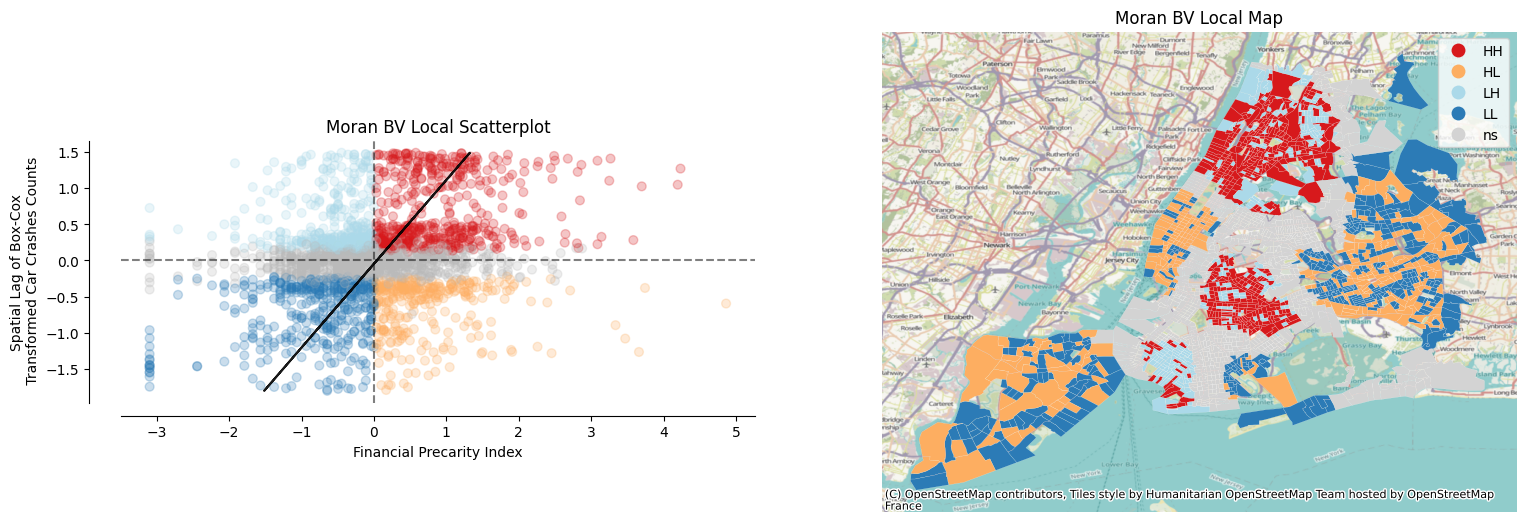

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

moran_scatterplot(moran_bv, nyc, p=0.0025, ax=axes[0], scatter_kwds={'alpha':0.25})
axes[0].set_xlabel('Financial Precarity Index')
axes[0].set_ylabel('Spatial Lag of Box-Cox\n Transformed Car Crashes Counts')

axes[1].set_title('Moran BV Local Map')

lisa_cluster(moran_bv, nyc, p=0.0025, ax=axes[1])
ctxly.add_basemap(axes[1], crs=nyc.crs.to_string())

In [9]:
import pygris

# Retrieve cartographic boundaries
tracts = pygris.tracts(state='ny', cb=True)
nyc_nice = nyc.drop('geometry', axis=1).merge(tracts[['GEOID', 'geometry']], how='left', on='GEOID')
orig = orig.drop('geometry', axis=1).merge(tracts[['GEOID', 'geometry']], how='left', on='GEOID')

Using the default year of 2021
Using FIPS code '36' for input 'ny'


In [10]:
nyc_nice.shape, nyc.shape

((2273, 27), (2273, 27))

In [11]:
nyc_nice = gpd.GeoDataFrame(nyc_nice, geometry=nyc_nice.geometry, crs=tracts.crs)
orig = gpd.GeoDataFrame(orig, geometry=orig.geometry, crs=tracts.crs)

In [12]:
minx, miny, maxx, maxy = nyc_nice.dissolve().bounds.loc[0]

In [13]:
nj_tracts = pygris.tracts(state='nj', cb=True, cache=True)
nj_tracts = nj_tracts[nj_tracts.AWATER < 1000000]
display_tracts = pd.concat([nj_tracts, tracts])
display_tracts = display_tracts[display_tracts.ALAND / display_tracts.AWATER > .9]
display_tracts['geometry'] = display_tracts.geometry\
    .to_crs('epsg:2263')\
    .buffer(1000, join_style=1)\
    .buffer(-990, join_style=1)\
    .to_crs(nyc_nice.crs)

display_tracts = display_tracts.dissolve(by='STATEFP')

Using the default year of 2021
Using FIPS code '34' for input 'nj'


In [14]:
display_tracts

,geometry,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER
STATEFP,,,,,,,,,,,,,
34,"MULTIPOLYGON (((-75.16948 39.38624, -75.16947 ...",029,720104,1400000US34029720104,34029720104,7201.04,Census Tract 7201.04,NJ,Ocean County,New Jersey,CT,2258412,7079
36,"MULTIPOLYGON (((-79.23442 41.99892, -79.24975 ...",081,014700,1400000US36081014700,36081014700,147,Census Tract 147,NY,Queens County,New York,CT,147950,0


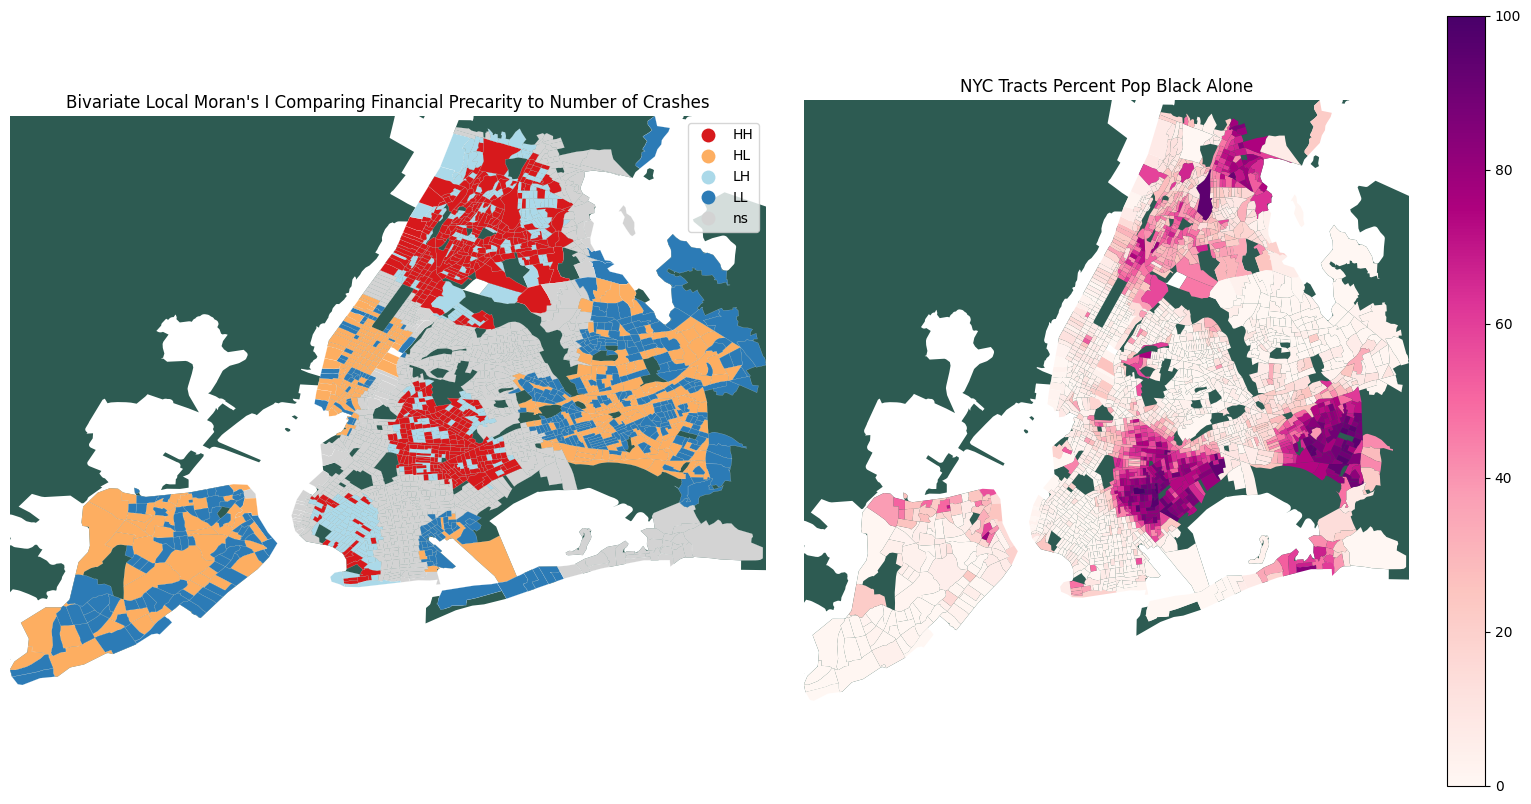

In [59]:
#tracts_backdrop = tracts[tracts.ALAND / tracts.AWATER > .9].dissolve()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)
for ax in axes:
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
    display_tracts.plot(ax=ax, color='#2d5b52')
    ax.set_axis_off()

    # ax.set_facecolor('#B7D0FF')
    # for spine in ax.spines.values():
    #     spine.set_visible(False)
    # ax.tick_params(bottom=False, labelbottom=False,
    #             left=False, labelleft=False)


nyc_nice.plot('perBlack', ax=axes[1], legend=True, cmap='RdPu')
axes[1].set_title('NYC Tracts Percent Pop Black Alone')
axes[0].set_title('Bivariate Local Moran\'s I Comparing Financial Precarity to Number of Crashes')

lisa_cluster(moran_bv, nyc_nice, p=0.0025, ax=axes[0])

plt.savefig('../figures/bv_morans.png', bbox_inches='tight', dpi=900)

# Matching

In [16]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import geopandas as gpd
import helpers
import pygris 
import matplotlib.pyplot as plt
import contextily as ctxly
from sklearn.preprocessing import PowerTransformer, StandardScaler

In [17]:
nyc_data = gpd.read_file('../data/shapes/nyc_final.gpkg', arrow=True).dropna()

nyc_data['treatment_grade'] = nyc_data.grade\
    .apply(lambda x: 1 if x in ['A', 'B'] else -1)
nyc_data['treatment_grade_race'] = nyc_data[['grade', 'nyn_agg']]\
    .apply(helpers.assign_race_grade_treatment, axis=1)
nyc_data['cd_white'] = nyc_data[['grade', 'nyn_agg']]\
    .apply(helpers.assign_cd_white, axis=1)

pt = PowerTransformer()
ss = StandardScaler()

nyc_data.set_index('GEOID', inplace=True)

nyc_data = nyc_data[nyc_data['totalPop'] != 0]

data = nyc_data.copy()\
    .drop(['HRI2010', 'grade', 'nyn_agg', 'geometry'], axis=1)

DO_NOT_TRANSFORM = ['numCrashes', 'treatment_grade', 'treatment_grade_race', 'cd_white', 'injCrashes', 'deathsCrashes']

data.loc[:, ['numCrashes', 'injCrashes', 'deathsCrashes']] = pt.fit_transform(data[['numCrashes', 'injCrashes', 'deathsCrashes']])
data.loc[:, ~data.columns.isin(DO_NOT_TRANSFORM)]\
    = ss.fit_transform(data.drop(DO_NOT_TRANSFORM, axis=1))

COMPARISON_VARS = ['numCrashes', 'FinPrec', 'injCrashes', 'deathsCrashes']

C:\Users\wimer\AppData\Local\Temp\ipykernel_40652\1736147301.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.20939643  0.13208915  0.38311572 ...  0.48038456 -0.7678532
  0.17029327]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, ['numCrashes', 'injCrashes', 'deathsCrashes']] = pt.fit_transform(data[['numCrashes', 'injCrashes', 'deathsCrashes']])
C:\Users\wimer\AppData\Local\Temp\ipykernel_40652\1736147301.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4555555  -0.02489776  0.21044813 ...  0.41739552 -0.82518333
 -0.4555555 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, ['numCrashes', 'injCrashes', 'deathsCrashes']] = pt.fit_transform(data[['numCrashes', 'injCrashes', 'deathsCrashes']])
C:\Users\wimer\AppData\Local\

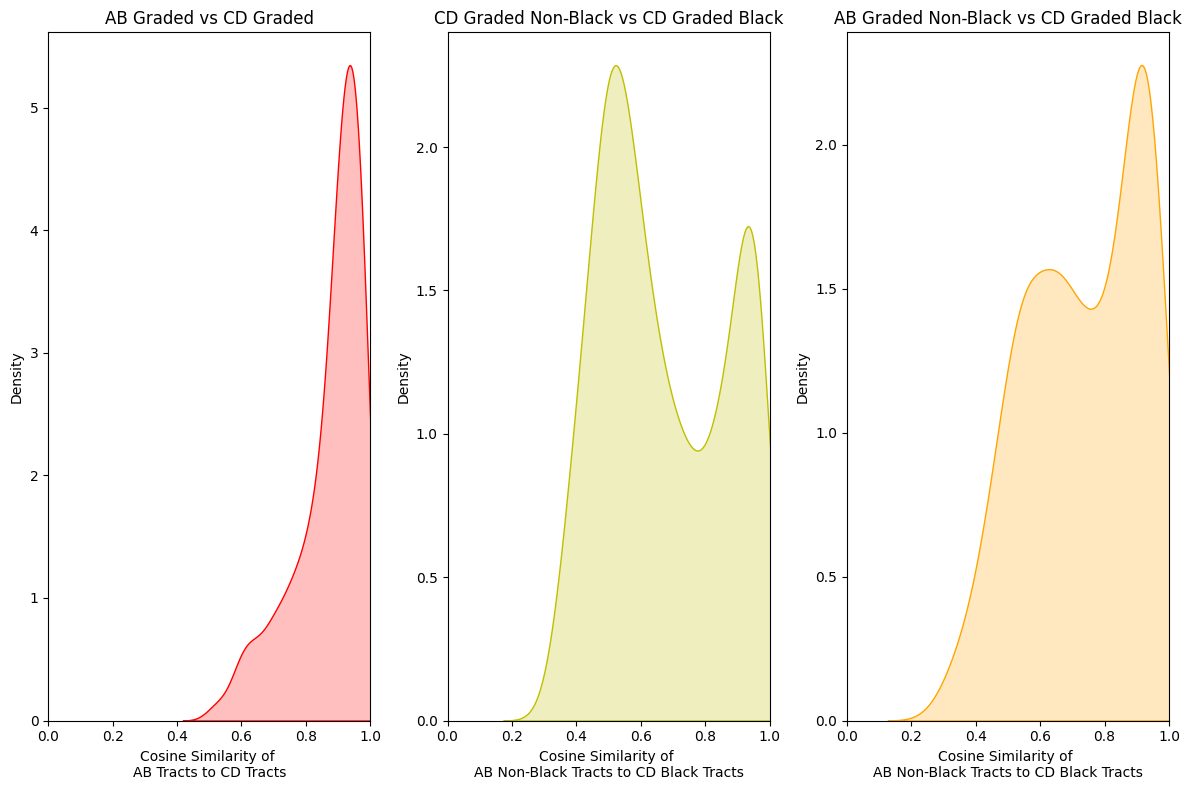

In [18]:
(treatment_grade, control_grade), (treatment_grade_race, control_grade_race), (treatment_cd, control_cd) = helpers.do_all_matching(data, to_exclude=['numCrashes', 'injCrashes', 'deathsCrashes', 'FinPrec'], save_loc='../figures/similarity_plots.svg')

.85, .8, .8 

In [19]:
helpers.make_comparisons(treatment_grade_race, control_grade_race, .85, nyc_data, COMPARISON_VARS)

treatment shape: (117, 22)
treatment index shape: (117,)
control_obs shape (117,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 41.35
        	  Median Treatment: 35.00,
        	  STD Treatment: 27.47
        	  n treatment: 117.00
        	Control:
        	  Mean Control: 45.23
        	  Median Control: 37.00,
        	  STD Control: 30.40
        	  n control: 117.00
        	Differences:
        	  Mean Difference: 3.88
        	  Median Difference: 3.88
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -3.71
        	  Median Treatment: -3.73,
        	  STD Treatment: 1.27
        	  n treatment: 117.00
        	Control:
        	  Mean Control: -3.06
        	  Median Control: -2.80,
        	  STD Control: 1.23
        	  n control: 117.00
        	Differences:
        	  Mean Difference

In [20]:
helpers.make_comparisons(treatment_grade, control_grade, .85, nyc_data, COMPARISON_VARS)

treatment shape: (256, 22)
treatment index shape: (256,)
control_obs shape (256,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 37.28
        	  Median Treatment: 32.00,
        	  STD Treatment: 23.60
        	  n treatment: 256.00
        	Control:
        	  Mean Control: 43.89
        	  Median Control: 43.00,
        	  STD Control: 24.45
        	  n control: 256.00
        	Differences:
        	  Mean Difference: 6.61
        	  Median Difference: 6.61
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -3.80
        	  Median Treatment: -3.75,
        	  STD Treatment: 1.60
        	  n treatment: 256.00
        	Control:
        	  Mean Control: -3.50
        	  Median Control: -3.36,
        	  STD Control: 1.45
        	  n control: 256.00
        	Differences:
        	  Mean Difference

In [21]:
helpers.make_comparisons(treatment_cd, control_cd, .85, nyc_data, COMPARISON_VARS)

treatment shape: (237, 22)
treatment index shape: (237,)
control_obs shape (237,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 46.15
        	  Median Treatment: 36.00,
        	  STD Treatment: 36.91
        	  n treatment: 237.00
        	Control:
        	  Mean Control: 48.00
        	  Median Control: 40.00,
        	  STD Control: 26.59
        	  n control: 237.00
        	Differences:
        	  Mean Difference: 1.85
        	  Median Difference: 1.85
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -3.42
        	  Median Treatment: -3.37,
        	  STD Treatment: 1.74
        	  n treatment: 237.00
        	Control:
        	  Mean Control: -3.20
        	  Median Control: -3.34,
        	  STD Control: 1.66
        	  n control: 237.00
        	Differences:
        	  Mean Difference

Socioeconomic matching:

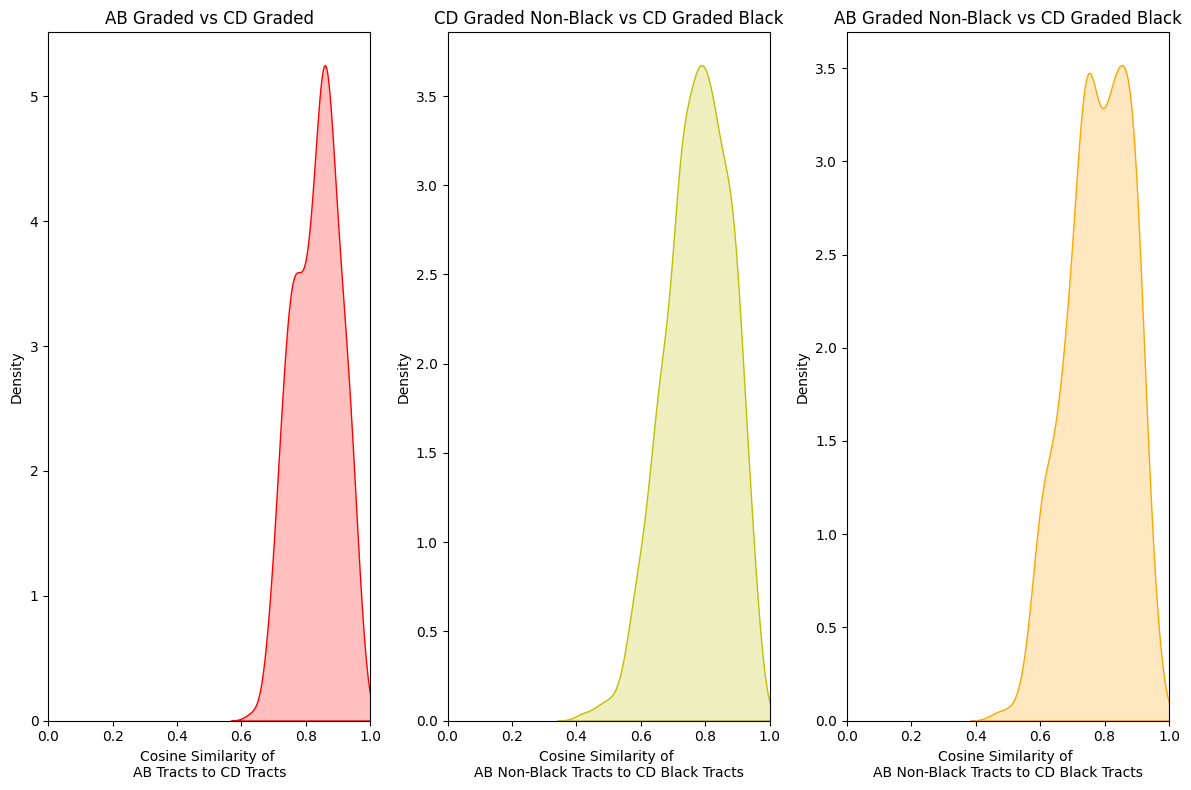

In [22]:
GRAPH_VARIABLES = [f"embed{i}" for i in range(128)]

(treatment_grade, control_grade), (treatment_grade_race, control_grade_race), (treatment_cd, control_cd) = helpers.do_all_matching(data, ['numCrashes', 'deathsCrashes', 'injCrashes', 'FinPrec'] + GRAPH_VARIABLES)

.7, .65, .65

In [23]:
helpers.make_comparisons(treatment_grade, control_grade, .85, nyc_data, COMPARISON_VARS)

treatment shape: (165, 22)
treatment index shape: (165,)
control_obs shape (165,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 39.46
        	  Median Treatment: 36.00,
        	  STD Treatment: 25.68
        	  n treatment: 165.00
        	Control:
        	  Mean Control: 44.44
        	  Median Control: 42.00,
        	  STD Control: 28.14
        	  n control: 165.00
        	Differences:
        	  Mean Difference: 4.98
        	  Median Difference: 4.98
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -4.24
        	  Median Treatment: -4.46,
        	  STD Treatment: 2.01
        	  n treatment: 165.00
        	Control:
        	  Mean Control: -4.13
        	  Median Control: -4.88,
        	  STD Control: 2.03
        	  n control: 165.00
        	Differences:
        	  Mean Difference

In [24]:
helpers.make_comparisons(treatment_grade_race, control_grade_race, .85, nyc_data, COMPARISON_VARS)

treatment shape: (90, 22)
treatment index shape: (90,)
control_obs shape (90,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 44.01
        	  Median Treatment: 42.00,
        	  STD Treatment: 27.34
        	  n treatment: 90.00
        	Control:
        	  Mean Control: 51.19
        	  Median Control: 53.00,
        	  STD Control: 26.53
        	  n control: 90.00
        	Differences:
        	  Mean Difference: 7.18
        	  Median Difference: 7.18
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -4.73
        	  Median Treatment: -5.13,
        	  STD Treatment: 1.78
        	  n treatment: 90.00
        	Control:
        	  Mean Control: -4.34
        	  Median Control: -5.13,
        	  STD Control: 1.65
        	  n control: 90.00
        	Differences:
        	  Mean Difference: 0.39


In [25]:
helpers.make_comparisons(treatment_cd, control_cd, .85, nyc_data, COMPARISON_VARS)

treatment shape: (235, 22)
treatment index shape: (235,)
control_obs shape (235,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 46.99
        	  Median Treatment: 38.00,
        	  STD Treatment: 46.48
        	  n treatment: 235.00
        	Control:
        	  Mean Control: 54.00
        	  Median Control: 51.00,
        	  STD Control: 31.84
        	  n control: 235.00
        	Differences:
        	  Mean Difference: 7.01
        	  Median Difference: 7.01
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -3.63
        	  Median Treatment: -4.04,
        	  STD Treatment: 2.10
        	  n treatment: 235.00
        	Control:
        	  Mean Control: -3.47
        	  Median Control: -3.64,
        	  STD Control: 2.09
        	  n control: 235.00
        	Differences:
        	  Mean Difference

matching on streets

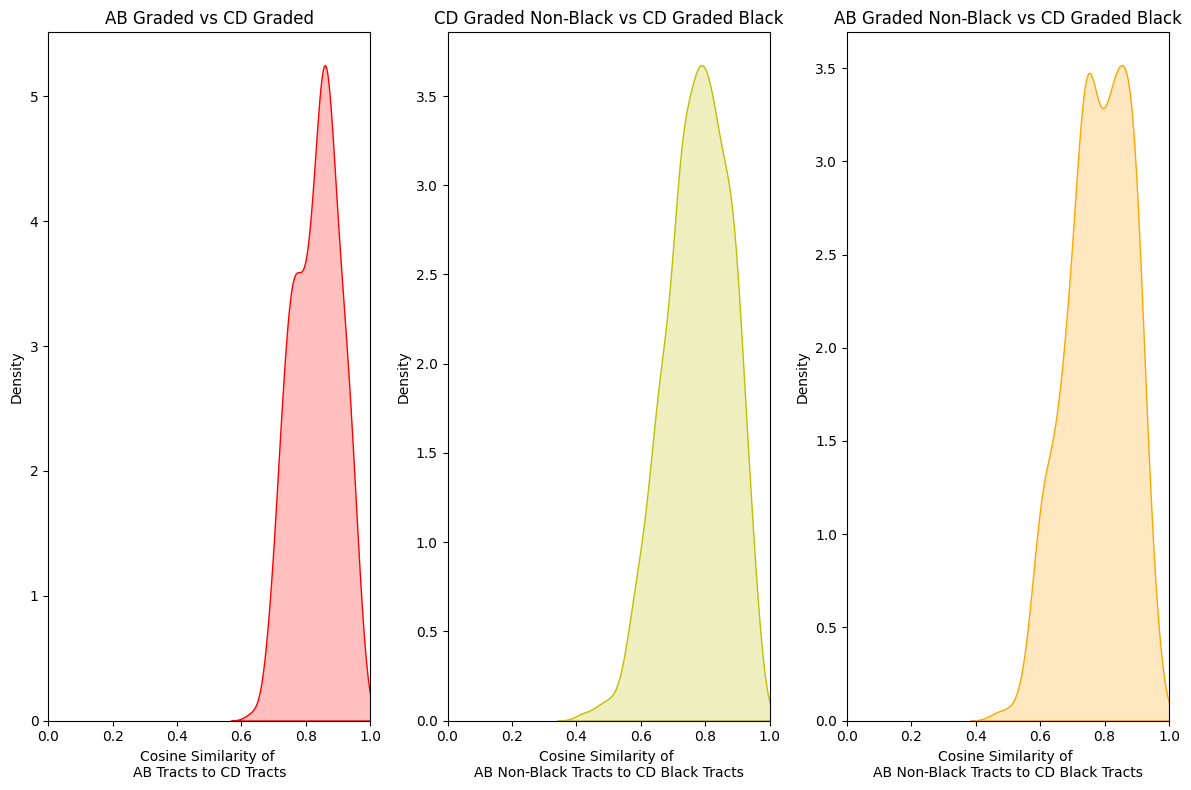

In [26]:
GRAPH_VARIABLES = [f"embed{i}" for i in range(128)]
to_exclude = [col for col in data.columns if col in GRAPH_VARIABLES]

(treatment_grade, control_grade), (treatment_grade_race, control_grade_race), (treatment_cd, control_cd) = helpers.do_all_matching(data, ['numCrashes', 'deathsCrashes', 'injCrashes', 'FinPrec'] + to_exclude)

.7, .75, .6

In [27]:
helpers.make_comparisons(treatment_grade, control_grade, .85, nyc_data, COMPARISON_VARS)

treatment shape: (165, 22)
treatment index shape: (165,)
control_obs shape (165,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 39.46
        	  Median Treatment: 36.00,
        	  STD Treatment: 25.68
        	  n treatment: 165.00
        	Control:
        	  Mean Control: 44.44
        	  Median Control: 42.00,
        	  STD Control: 28.14
        	  n control: 165.00
        	Differences:
        	  Mean Difference: 4.98
        	  Median Difference: 4.98
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -4.24
        	  Median Treatment: -4.46,
        	  STD Treatment: 2.01
        	  n treatment: 165.00
        	Control:
        	  Mean Control: -4.13
        	  Median Control: -4.88,
        	  STD Control: 2.03
        	  n control: 165.00
        	Differences:
        	  Mean Difference

In [28]:
helpers.make_comparisons(treatment_grade_race, control_grade_race, .85, nyc_data, COMPARISON_VARS)

treatment shape: (90, 22)
treatment index shape: (90,)
control_obs shape (90,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 44.01
        	  Median Treatment: 42.00,
        	  STD Treatment: 27.34
        	  n treatment: 90.00
        	Control:
        	  Mean Control: 51.19
        	  Median Control: 53.00,
        	  STD Control: 26.53
        	  n control: 90.00
        	Differences:
        	  Mean Difference: 7.18
        	  Median Difference: 7.18
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -4.73
        	  Median Treatment: -5.13,
        	  STD Treatment: 1.78
        	  n treatment: 90.00
        	Control:
        	  Mean Control: -4.34
        	  Median Control: -5.13,
        	  STD Control: 1.65
        	  n control: 90.00
        	Differences:
        	  Mean Difference: 0.39


In [29]:
helpers.make_comparisons(treatment_cd, control_cd, .85, nyc_data, COMPARISON_VARS)

treatment shape: (235, 22)
treatment index shape: (235,)
control_obs shape (235,)
----------------------------------------------
        numCrashes:
        	Treatment:
        	  Mean Treatment: 46.99
        	  Median Treatment: 38.00,
        	  STD Treatment: 46.48
        	  n treatment: 235.00
        	Control:
        	  Mean Control: 54.00
        	  Median Control: 51.00,
        	  STD Control: 31.84
        	  n control: 235.00
        	Differences:
        	  Mean Difference: 7.01
        	  Median Difference: 7.01
        ----------------------------------------------
        ----------------------------------------------
        FinPrec:
        	Treatment:
        	  Mean Treatment: -3.63
        	  Median Treatment: -4.04,
        	  STD Treatment: 2.10
        	  n treatment: 235.00
        	Control:
        	  Mean Control: -3.47
        	  Median Control: -3.64,
        	  STD Control: 2.09
        	  n control: 235.00
        	Differences:
        	  Mean Difference